In [2]:
import numpy as np
import pandas as pd
from ast import literal_eval
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
models_ran = [
    'LC_discrete_attention',
    'change_d_obs_fk',
    'change_d_obs_cause_effect',
    'change_d_obs_cause',
    'LC_discrete',
    'normative',
    'ces_strength',
    'ces_no_strength'
]

file_tags = [
    ['att', 'att_prior'],
    ['att_cha', 'att_cha_prior'],
    ['att_cha'],
    ['att_cha'],
    [1, 'prior'],
    [1, 'prior'],
    [1],
    [1]
]

model_labels = [
    ['LC w. attention', 'LC w. attention w. prior'],
    ['Change w. full knowledge', 'Change w. full knowledge w. prior'],
    ['Change linear cause effect'],
    ['Change linear cause'],
    ['LC basic', 'LC basic w. prior'],
    ['normative', 'normative w. prior'],
    ['CES strength sensitive'],
    ['CES basic']
]

model_names = []
for names in model_labels:
    model_names += names

color_dict = {
    'LC w. attention': tuple(sns.light_palette("seagreen")[-1]), 
    'LC w. attention w. prior': tuple(sns.light_palette("seagreen")[-2]),
    'Change w. full knowledge': tuple(sns.color_palette("mako")[1]), 
    'Change w. full knowledge w. prior': tuple(sns.color_palette("mako")[2]),
    'Change linear cause effect': tuple(sns.color_palette("mako")[3]),
    'Change linear cause': tuple(sns.color_palette("mako")[4]),
    'LC basic': tuple(sns.color_palette("Paired")[5]),
    'LC basic w. prior': tuple(sns.color_palette("Paired")[4]),
    'normative': tuple(sns.color_palette("Set2")[-3]), 
    'normative w. prior': tuple(sns.color_palette("Paired")[-2]),
    'CES strength sensitive': tuple(sns.color_palette("YlOrBr")[4]),
    'CES basic': tuple(sns.color_palette("YlOrBr")[3]),
    'Baseline': tuple(sns.color_palette("Set2")[-1])
}
# CES prior : sns.color_palette("YlOrBr").as_hex()[3]
# CES strength insensitive: sns.color_palette("YlOrBr").as_hex()[2]

## Dictionary for color allocation
def gen_colors(labels, color_dict):
    return [color_dict[label] for label in labels]

In [4]:
# Import datasets
df = pd.DataFrame()
for i, model in enumerate(models_ran):
    for j, tag in enumerate(file_tags[i]):
        if df.empty:
            df = pd.read_csv(f'./data/params_fitting_outputs/{model}/summary_fit_{tag}.csv')
            df = df.replace([model], [model_labels[i][j]])
            df['tag'] = tag
            df['folder'] = model
    
        else:
            df_2 = pd.read_csv(f'./data/params_fitting_outputs/{model}/summary_fit_{tag}.csv')
            df_2 = df_2.replace([model], [model_labels[i][j]])
            df_2['tag'] = tag
            df_2['folder'] = model
            df = pd.concat([df, df_2], axis=0, ignore_index=True)


experiments_series = df_2.experiment.to_list()
#df = df.drop(['Unnamed: 0'], axis=1)
pids = df.pid.unique()
df.model_name.unique()

array(['LC w. attention', 'LC w. attention w. prior',
       'Change w. full knowledge', 'Change w. full knowledge w. prior',
       'Change linear cause effect', 'Change linear cause', 'LC basic',
       'LC basic w. prior', 'normative', 'normative w. prior',
       'CES strength sensitive', 'CES basic'], dtype=object)

In [5]:
print(f'Number of lost trials: {df.bic.isna().sum()} out of {df.shape[0]}')
print(f'Number of not completely successful optimisation: {(df.success == False).sum()} out of {df.shape[0]}')

Number of lost trials: 5 out of 3624
Number of not completely successful optimisation: 5 out of 3624


In [7]:
pids = df.pid.unique()
df['best_fit'] = np.nan

for pid in pids:
    df_pid = df[df.pid == pid].sort_values('bic')
    df.loc[df.pid == pid, 'best_fit'] = df_pid.model_name.to_list()[0]

df_bic = pd.DataFrame(index=df.pid.unique(), columns=model_names)
for model in model_names:
    df_bic[model] = df[df.model_name == model].bic.to_list()

df_bic = df_bic[df_bic.mean().sort_values().index]
df_bic['Baseline'] = -2 * 4 * np.log(1/5**6)
df_bic['experiment'] = experiments_series


baseline_group = -2 * (302 *4) * np.log(1/5**6)
baseline_group

23330.411978644723

### Exports of reprocessed data

#### Prior temperature for change and lc attention

In [83]:

select_lc_attention = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Baseline'
]
select_change = [
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'Baseline'
]

df_prior = pd.DataFrame(index=pids, columns=['experiment', 'lc_bic', 'lc_prior', 'change_bic', 'change_prior'])

df_prior['experiment'] = experiments_series
df_prior['lc_bic'] = df[df.model_name == 'LC w. attention w. prior'].bic.to_list()
df_prior['change_bic'] = df[df.model_name == 'Change w. full knowledge w. prior'].bic.to_list()

df_prior['lc_prior'] = df[df.model_name == 'LC w. attention w. prior'].apply(lambda x: float(" ".join(x.params[1:-1].split()).split(' ')[-1]), axis=1).to_list()
df_prior['change_prior'] = df[df.model_name == 'Change w. full knowledge w. prior'].apply(lambda x: float(" ".join(x.params[1:-1].split()).split(' ')[-1]), axis=1).to_list()

df_prior['best_change'] = df_bic[select_change].apply(lambda x: np.argmin(x), axis=1)
#df_prior['best_change'] = df_prior['best_change'].replace(np.arange(len(select_change)), select_change)

df_prior['best_lc'] = df_bic[select_lc_attention].apply(lambda x: np.argmin(x), axis=1)
#df_prior['best_lc'] = df_prior['best_lc'].replace(np.arange(len(select_lc_attention)), select_lc_attention)
df_prior.to_csv('/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/data/prior_fitting_data.csv', index=False)

#### Parameter values expansion for all models

- Index: PID
- Columns:
    - experiment
    - Parameters 1 to n

In [111]:
fitted_params_dict = {}

for i, model in enumerate(model_names):
    
    df_model = df[df.model_name == model]
    df_params = pd.DataFrame(index=df_model.pid)
    #df_params['experiment'] = df_model.experiment.to_list()

    folder = df_model.loc[df_model.index[0], 'folder']
    tag = df_model.loc[df_model.index[0], 'tag']

    params, indices = zip(*literal_eval(df_model.loc[df_model.index[0], 'params_labels']))
    columns = []
    for j in range(len(params)):
        columns.append(params[indices.index(j)])

    for j, col in enumerate(columns): 
        df_params[col] = df_model.apply(lambda x: float(" ".join(x.params[1:-1].split()).split(' ')[j]), axis=1).to_list()

    
    for j, pid in enumerate(df_params.index):
        if i == 0:
            fitted_params_dict[pid] = {}

        part_data = df_params.loc[pid].to_dict()
        fitted_params_dict[pid][folder +'_&_'+ str(tag)] = part_data
    #df_params.to_csv(f'./data/params_fitting_outputs/{folder}/parameters_{tag}.csv')

with open('./data/params_fitting_outputs/fitted_params.json', 'w') as outfile:
    json.dump(fitted_params_dict, outfile)


#fitted_params_dict

### Model fitting graphs

In [85]:
print('Sample wide model fit:')
df.groupby('model_name').bic.mean().sort_values()

Sample wide model fit:


model_name
LC w. attention w. prior             57.638976
LC w. attention                      58.684008
Change w. full knowledge             59.598810
Change w. full knowledge w. prior    60.034618
normative                            62.111174
Change linear cause effect           62.507195
normative w. prior                   63.364058
LC basic                             64.577082
LC basic w. prior                    64.950011
Change linear cause                  67.894993
CES strength sensitive               72.323016
CES basic                            72.713133
Name: bic, dtype: float64

In [86]:
experiments = df.experiment.unique()
for i, experiment in enumerate(experiments):
    df_exp = df[df.experiment == experiment]
    print(f'Experiment {i+1} model fits:')
    print(df_exp.groupby('model_name').bic.mean().sort_values())
    print()

Experiment 1 model fits:
model_name
LC w. attention                      53.716737
LC w. attention w. prior             54.359072
Change w. full knowledge             55.142775
normative                            55.360258
Change w. full knowledge w. prior    56.496434
normative w. prior                   56.735143
Change linear cause effect           58.820632
LC basic                             59.583299
LC basic w. prior                    60.593788
Change linear cause                  62.949897
CES strength sensitive               74.663848
CES basic                            75.101696
Name: bic, dtype: float64

Experiment 2 model fits:
model_name
LC w. attention w. prior             62.265592
LC w. attention                      63.573887
Change w. full knowledge             63.686773
Change w. full knowledge w. prior    63.897686
Change linear cause effect           65.565858
normative                            66.552735
normative w. prior                   67.744154
LC basic

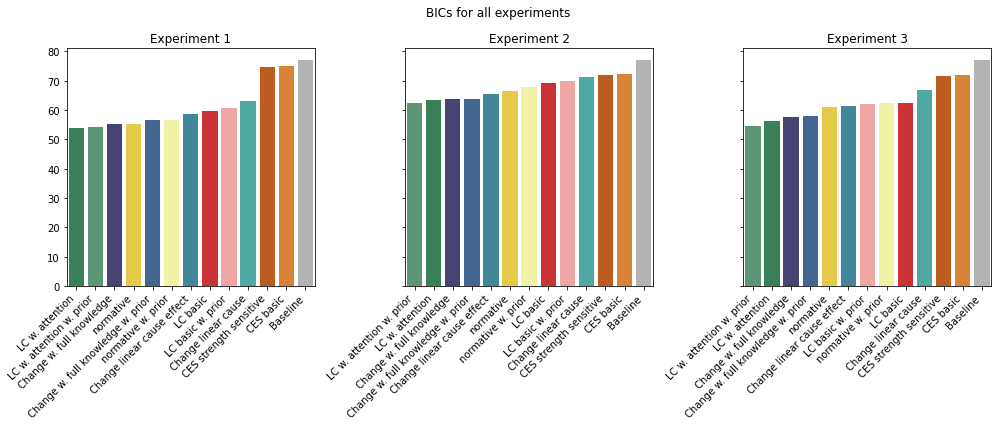

In [87]:

fig, axs = plt.subplots(1, len(experiments), figsize=(14, 6), sharey=True)

for i, experiment in enumerate(experiments):
    df_exp = df_bic[df_bic.experiment == experiment]
    df_exp_plot = df_exp[[col for col in df_exp.columns if col != 'experiment']]
    df_exp_plot = df_exp_plot[df_exp_plot.mean().sort_values().index]

    colors = gen_colors(df_exp_plot.columns, color_dict)
    sns.set_palette(colors)
    sns.barplot(data=df_exp_plot, ax=axs[i], ci=None)
    axs[i].set_xticklabels(df_exp_plot.columns, rotation=45, ha='right')
    axs[i].set_title(f'Experiment {experiment[-1]}')

fig.suptitle('BICs for all experiments')
plt.tight_layout()
plt.show()

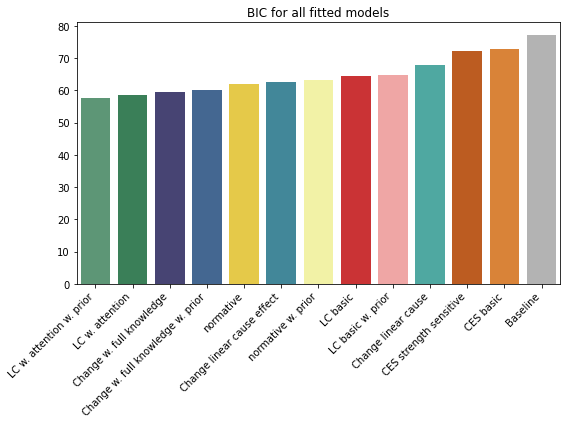

In [88]:
df_bic_plot = df_bic[[col for col in df_bic.columns if col != 'experiment']]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=ax, ci=None)
ax.set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
ax.set_title('BIC for all fitted models')
plt.tight_layout()
plt.show()

In [89]:
select_all = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'normative',
    'normative w. prior',
    'LC basic',
    'LC basic w. prior',
    'CES_strength_sensitive',
    'Baseline'
]
select_lc_attention = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Baseline'
]
select_lc = [
    'LC basic',
    'LC basic w. prior',
    'Baseline'
]
select_change = [
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'Change linear cause effect',
    'Change linear cause'
    'Baseline'
]
select_normative = [
    'normative',
    'normative w. prior',
    'Baseline'
]
select_ces = [
    'CES_strength_sensitive',
    'Baseline'
]

selections = {
    'select_all' : [
        'LC w. attention',
        'Change w. full knowledge',
        'normative',
        'LC basic',
        'CES strength sensitive',
        'Baseline'
    ],
    'select_lc_attention' : [
        'LC w. attention',
        'LC w. attention w. prior',
        'Baseline'
    ],
    'select_lc' : [
        'LC basic',
        'LC basic w. prior',
        'Baseline'
    ],
    'select_change' : [
        'Change w. full knowledge',
        'Change linear cause effect',
        'Change linear cause',
        'Baseline'
    ],
    'select_change_prior' : [
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'Baseline'
    ],
    'select_normative' : [
        'normative',
        'normative w. prior',
        'Baseline'
    ],
    'select_ces' : [
        'CES strength sensitive',
        'CES basic',
        'Baseline'
    ]
}

selections_titles = [
    'Key models',
    'Local computations attention models prior comparison',
    'Local computations basic models prior comparison',
    'Change models comparison',
    'Change models prior comparison',
    'Normative models prior comparison',
    'Causal event segmentation models comparison'
]

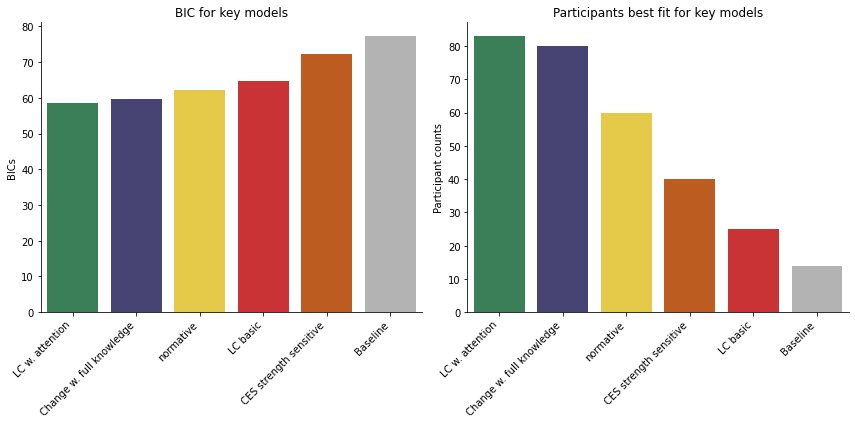

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
select = 'select_all'

# BICS
df_bic_plot = df_bic[[col for col in df_bic.columns if col not in ['experiment', 'best']]][selections[select]]

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=axs[0], ci=None)
axs[0].set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
axs[0].set_title('BIC for key models')

axs[0].set_ylabel('BICs')

# Participants' best fit

df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])

axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')

axs[1].set_title('Participants best fit for key models')

axs[1].set_ylabel('Participant counts')

sns.despine()
plt.tight_layout()
plt.show()

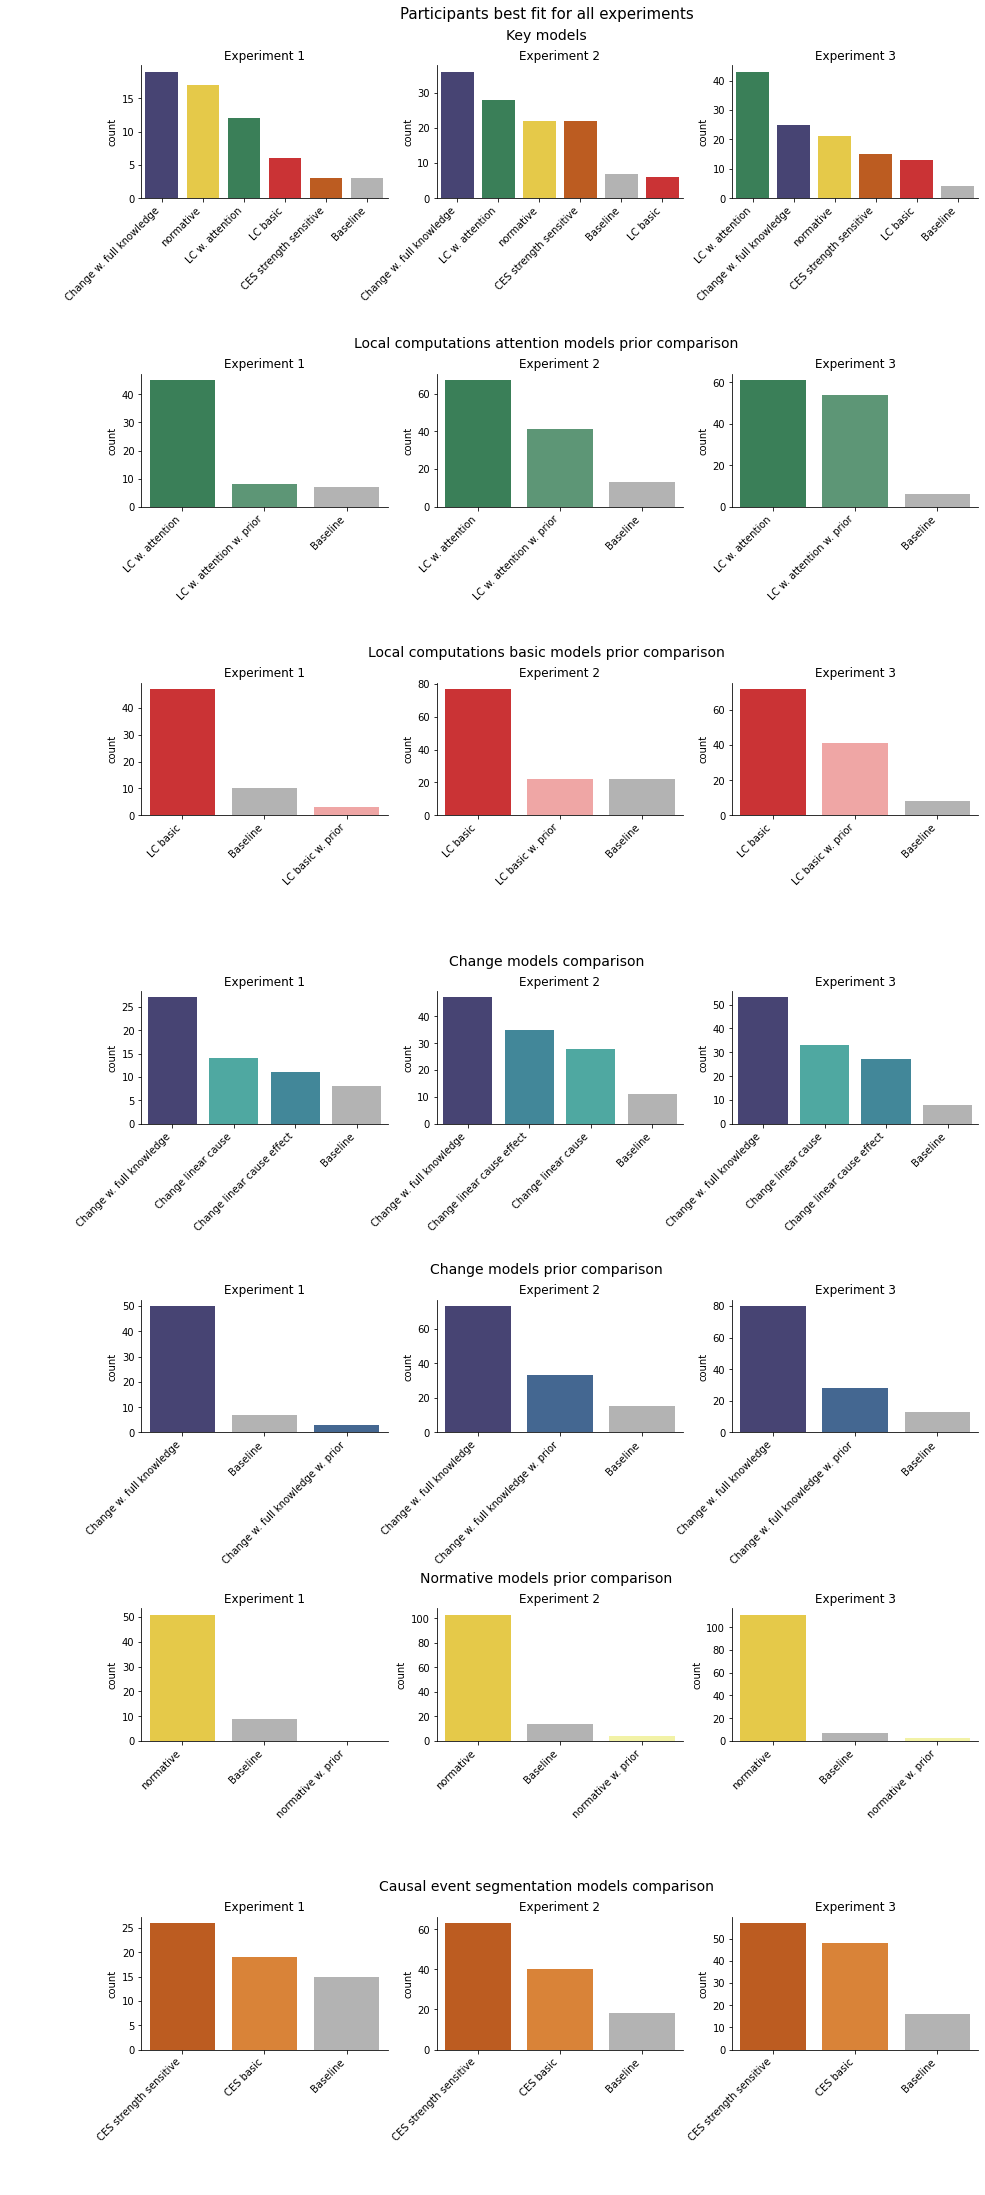

In [91]:
#fig, axs = plt.subplots(len(selections), len(experiments), figsize=(15, 30))

fig = plt.figure(figsize=(15, 30))

subfigs = fig.subfigures(nrows=len(selections), ncols=1)
for i, select in enumerate(selections.keys()):
    subfigs[i].suptitle(f'{selections_titles[i]}', y=1, fontsize=14)

    axs = subfigs[i].subplots(nrows=1, ncols=len(experiments))
    
    df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

    subfigs[i].subplots_adjust(left=None, bottom=0.45, right=None, top=None, wspace=None, hspace=None)
    
    for j, experiment in enumerate(experiments):
        df_exp = df_bic[df_bic.experiment == experiment]
        df_exp_plot = df_exp[['best', 'experiment']]

        df_order = pd.DataFrame(index=selections[select])
        df_order['counts'] = 0
        df_order.loc[df_exp_plot.best.value_counts().index, 'counts'] = df_exp_plot.best.value_counts().values

        colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
        sns.set_palette(colors)

        sns.countplot(x='best', data=df_exp_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[j])
        axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=45, ha='right')
        axs[j].set_xlabel('')
        axs[j].set_title(f'Experiment {experiment[-1]}')
        
        sns.despine(ax=axs[j])

fig.suptitle('Participants best fit for all experiments', fontsize=15, y=1.01)
#plt.tight_layout()
plt.show()

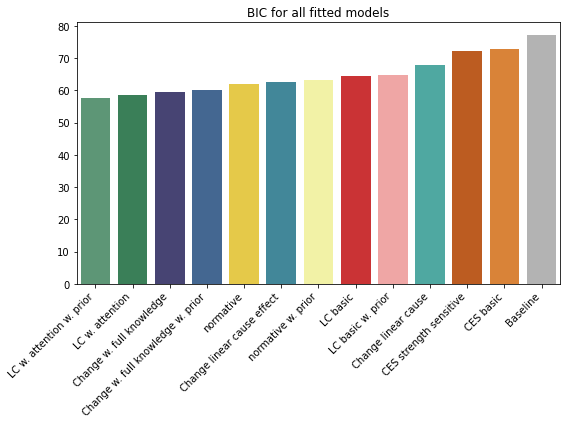

In [92]:
df_bic_plot = df_bic[[col for col in df_bic.columns if col not in ['experiment', 'best']]]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=ax, ci=None)
ax.set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
ax.set_title('BIC for all fitted models')
plt.tight_layout()
plt.show()

In [19]:
select_keys = {
    'attention' : [
        'LC w. attention',
        'LC w. attention w. prior',
        'Baseline'
    ],
    'change' : [
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'Baseline'
    ]
}

for i, select in enumerate(select_keys.keys()):
    df_bic[f'best_{select}'] = df_bic[select_keys[select]].apply(lambda x: np.argmin(x), axis=1)
    df_bic[f'best_{select}'] = df_bic[f'best_{select}'].replace(np.arange(len(select_keys[select])), select_keys[select])

In [20]:
prior_best_attention = df_bic[df_bic.best_attention == 'LC w. attention w. prior'].index
prior_best_change = df_bic[df_bic.best_change == 'Change w. full knowledge w. prior'].index

In [21]:
print(prior_best_attention.size)
print(prior_best_change.size)

intersection = list(set(prior_best_attention).intersection(prior_best_change))

df_prior_att = df[df.model_name.isin(['LC w. attention w. prior'])]
df_prior_change = df[df.model_name.isin(['change w. full knowledge w. prior'])]
df_prior = df[df.model_name.isin(['LC w. attention w. prior', 'change w. full knowledge w. prior'])]

57
59
